## QD single/cluster visualization simulation
Simulating clustering of QDs that cause the zero-filling-in-effect as seen in our single QD/cluster detection method.

Everything in SI units (meters).

In [250]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import struve, jv
from scipy.signal import convolve2d
from scipy import sometrue, signal
from PIL import Image
import pandas as pd

In [246]:
# simulation parameters
size_pixel = 2e-9  # pixel size
size_sample = 0.8e-6  # image/sample size
lambda_sted = 775e-9  # STED wavelength
d_qd = 6e-9  # QD diameter
d_shift = d_qd * 3  # shift in center position for QDs in cluster
na = 1.4  # NA of objective
p_sted = 4  # STED beam power
qd_bright = 5  # qd brightness factor
shift_vector_9 = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,0],[0,1],[1,-1],[1,0],[1,1]]
shift_vector_25 = [[-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],[-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],[0,-2],[0,-1],[0,0],[0,1],[0,2],[1,-2],[1,-1],[1,0],[1,1],[1,2],[2,-2],[2,-1],[2,0],[2,1],[2,2]]
n_qds = [1,9]  # number of qds
exc_sat = 0.9 # donut saturation

# for donut calculation
h0 = np.array([])
h1 = np.array([])
j0 = np.array([])
j1 = np.array([])

x_do = np.linspace(0, size_sample, int(size_sample/size_pixel))

for i in x_do:
    h0 = np.append(h0, struve(0,i))
    h1 = np.append(h1, struve(1,i))
    j0 = np.append(j0, jv(0,i))
    j1 = np.append(j1, jv(1,i))

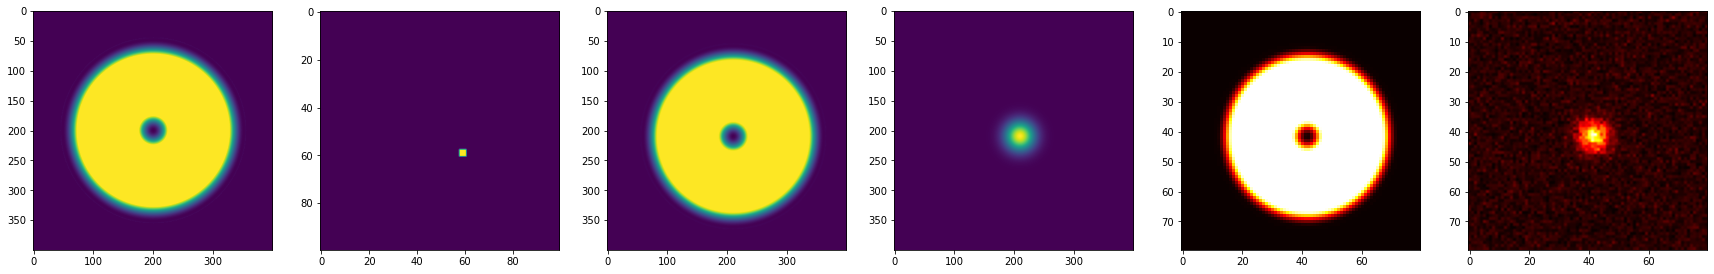

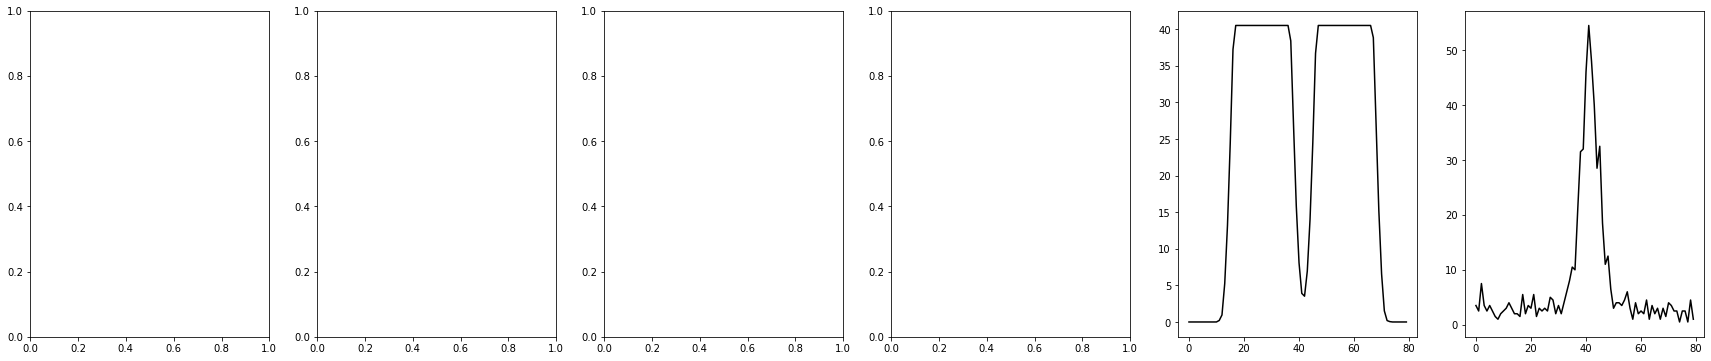

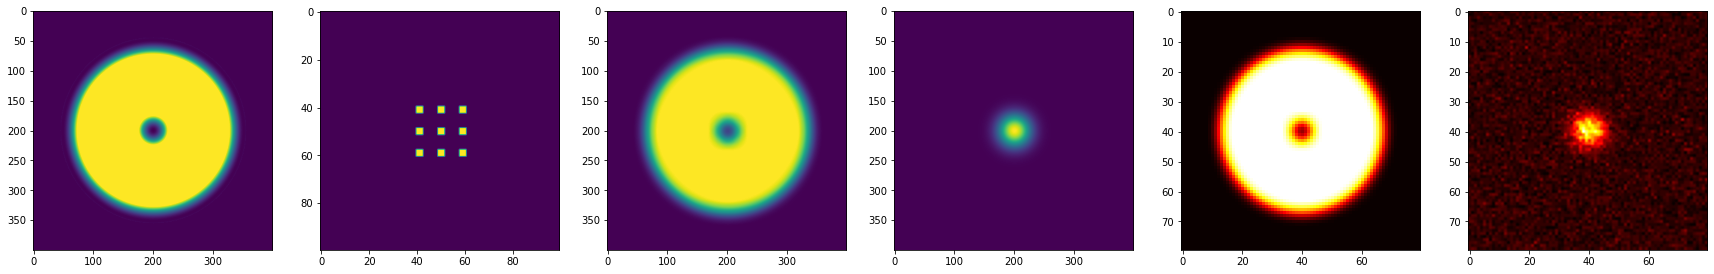

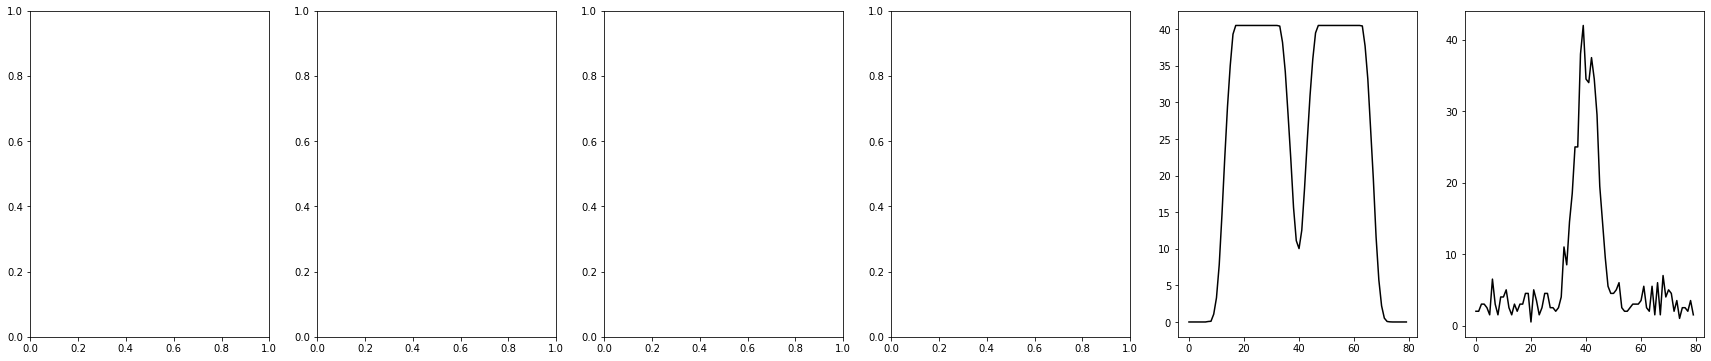

In [320]:
for n_qd in n_qds:
    n_pixels = int(np.ceil(size_sample/size_pixel))  # number of pixels to simulate
    r_qd = d_qd/2
    if n_qd < 10:
        shift_vector = shift_vector_9
    else:
        shift_vector = shift_vector_25

    # coordinate system in sample plane
    x = np.floor(range(int(-(n_pixels-1)/2)-1,int((n_pixels-1)/2)+1)) * size_pixel
    y = np.copy(x)
    X, Y = np.meshgrid(x,y)
    dx = x[1] - x[0]
    dy = np.copy(dx)
    R = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y,X)

    # create QD sample and donut pattern
    # QD sample
    sample_full = np.zeros(len(x))
    for i in range(n_qd):
        r_shift = np.sqrt((X + d_shift * shift_vector[i][0])**2 + (Y + d_shift * shift_vector[i][1])**2)
        sample_full = sample_full + (r_shift < r_qd)
    sample_full = sample_full * qd_bright / n_qd
    sample = sample_full[150:250,150:250]

    # create donut pattern
    # simple version (~correct crest distance, approx. 550 nm, should be ~510 nm in reality)
    #I_donut = np.sin(np.pi * R * na / lambda_sted)**2 * p_sted
    #I_donut[R > 5.5e-7] = 0
    # mimic distance in the images - looks like crest-crest is ~300 nm?
    I_donut = np.sin(np.pi * R * na / (lambda_sted / 1.83))**2 * p_sted
    I_donut[R > 3.1e-7] = 0
    I_donut[I_donut > exc_sat] = exc_sat
    
    # create effective excitation pattern
    def gkern(kernlen=21, std=3):
        """Returns a 2D Gaussian kernel array."""
        gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
        gkern2d = np.outer(gkern1d, gkern1d)
        return gkern2d
    
    I_exc = gkern(kernlen=400, std=40/2.355)

    # calculate the final emission - donut and exc
    img = convolve2d(I_donut,sample,mode='same')
    #img = img / np.sum(np.sum(sample))
    #img[img > exc_sat] = exc_sat
    img_exc = convolve2d(I_exc,sample,mode='same')
    
    fig,ax = plt.subplots(1,6,figsize=(30,6))
    im1 = ax[0].imshow(I_donut)
    #plt.colorbar(im1)
    ax[1].imshow(sample)
    ax[2].imshow(img)
    ax[3].imshow(img_exc)
    
    # generate realistic pixelated image
    # reshape image
    size_new = 80
    img_px = img.reshape(size_new, len(img) // size_new, size_new, len(img) // size_new).sum(3).sum(1)
    img_px = img_px / (len(img)/size_new)**2
    img_exc_px = img_exc.reshape(size_new, len(img_exc) // size_new, size_new, len(img_exc) // size_new).sum(3).sum(1)
    img_exc_px = img_exc_px / (len(img_exc)/size_new)**2

    # add noise to qd image - donut and exc
    #img_px = np.random.poisson(img_px)
    img_exc_px = np.random.poisson(img_exc_px)

    # generate bkg carpet and add to qd_img - donut and exc
    bkg_mean = 3
    rng = np.random.default_rng()
    bkg = rng.poisson(lam=bkg_mean, size=np.shape(img_px))
    #img_px = img_px + bkg
    img_exc_px = img_exc_px + bkg
    
    im3 = ax[4].imshow(img_px,vmin=0, cmap=plt.cm.get_cmap('hot'))
    #plt.colorbar(im3)
    im4 = ax[5].imshow(img_exc_px,vmin=0, cmap=plt.cm.get_cmap('hot'))
    #plt.colorbar(im4)
    plt.show()
    
    # plot line profiles
    fig2,ax2 = plt.subplots(1,6,figsize=(30,6))
    ax2[4].plot(np.mean(img_px[40:42],axis=0), 'k')
    ax2[5].plot(np.mean(img_exc_px[40:42],axis=0), 'k')

    img_donut_savename = 'donut-' + str(n_qd) + 'qds.tif'
    img_exc_savename = 'exc-' + str(n_qd) + 'qds.tif'
    im_donut = Image.fromarray(img_px.astype('uint8'))
    im_donut.save(img_donut_savename)
    im_exc = Image.fromarray(img_exc_px.astype('uint8'))
    im_exc.save(img_exc_savename)

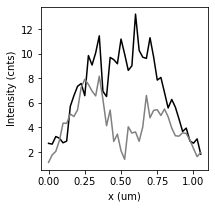

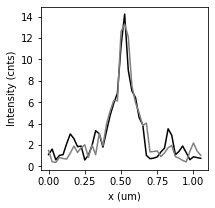

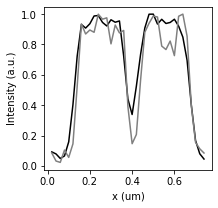

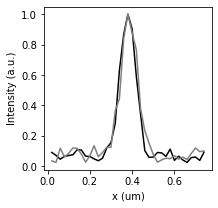

In [317]:
# line profile plotting
file_exp = 'LineProfs-singlevcluster-exp.xlsx'
file_sim = 'LineProfs-singlevcluster-sim.xlsx'
image_format = 'svg' # e.g .png, .svg, etc.
sz_fig = 3

data_exp = pd.read_excel(file_exp, header=0)
x = data_exp.iloc[13:-12,0]
x = x - x.iloc[0]
sted_only_cl = data_exp.iloc[13:-12,1]
sted_only_si = data_exp.iloc[13:-12,3]
sted_sub_cl = data_exp.iloc[13:-12,5]
sted_sub_si = data_exp.iloc[13:-12,7]

fig1 = plt.figure(figsize=(sz_fig,sz_fig))
plt.plot(x,sted_only_cl,'k')
plt.plot(x,sted_only_si,'gray')
plt.xlabel('x (um)')
plt.ylabel('Intensity (cnts)')
image_name = 'exp-stedonly-clvsi.svg'
fig1.savefig(image_name, format=image_format, dpi=1200)

fig2 = plt.figure(figsize=(sz_fig,sz_fig))
plt.plot(x,sted_sub_cl,'k')
plt.plot(x,sted_sub_si,'gray')
plt.xlabel('x (um)')
plt.ylabel('Intensity (cnts)')
image_name = 'exp-stedsub-clvsi.svg'
fig2.savefig(image_name, format=image_format, dpi=1200)

data_sim = pd.read_excel(file_sim, header=0)
x = data_sim.iloc[2:-1,0]
sted_only_cl = data_sim.iloc[1:-2,1]
sted_only_cl = sted_only_cl / np.max(sted_only_cl)
sted_only_si = data_sim.iloc[1:-2,3]
sted_only_si = sted_only_si / np.max(sted_only_si)
sted_sub_cl = data_sim.iloc[1:-2,5]
sted_sub_cl = sted_sub_cl / np.max(sted_sub_cl)
sted_sub_si = data_sim.iloc[2:-1,7]
sted_sub_si = sted_sub_si / np.max(sted_sub_si)

fig3 = plt.figure(figsize=(sz_fig,sz_fig))
plt.plot(x,sted_only_cl,'k')
plt.plot(x,sted_only_si,'gray')
plt.xlabel('x (um)')
plt.ylabel('Intensity (a.u.)')
image_name = 'sim-stedonly-clvsi.svg'
fig3.savefig(image_name, format=image_format, dpi=1200)

fig4 = plt.figure(figsize=(sz_fig,sz_fig))
plt.plot(x,sted_sub_cl,'k')
plt.plot(x,sted_sub_si,'gray')
plt.xlabel('x (um)')
plt.ylabel('Intensity (a.u.)')
image_name = 'sim-stedsub-clvsi.svg'
fig4.savefig(image_name, format=image_format, dpi=1200)
